In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.model_selection import cross_val_score
import numpy as np
from  sklearn.model_selection import GridSearchCV

In [2]:
train_df = pd.read_csv("data/titanic/train.csv")
test_df = pd.read_csv("data/titanic/test.csv")

In [3]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.describe(include="O")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Arnold-Franchi, Mr. Josef",male,1601,G6,S
freq,1,577,7,4,644


데이터를 전처리하기 전에 미리 데이터셋을 보고 어떤식으로 전처리할지 생각해본다
- 연관이 없을것 같은 값을 제거(PassengerId)
- Null값이 있을 시엔 어떤 방식으로 이를 처리할지(Age, Embarked)
- Null값이 과하게 많은 값 역시 제거(Cabin)
- **특성공학을 사용하여 라벨 값과 연관성이 높은 새로운 항을 만든다**
- 이후 라벨특성과 라벨과의 연관성이 낮은 특성을 제거하고 모델을 학습시킨다

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

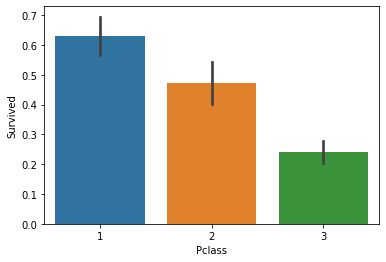

In [6]:
#그래프에 너무 집착하지 말고 특성에 대해 이해할 수 있다면 어떤 방식이든 상관없음
#각 그래프의 적절한 용도
#https://www.kaggle.com/alexisbcook/choosing-plot-types-and-custom-styles
sns.barplot(x=train_df["Pclass"], y=train_df["Survived"])

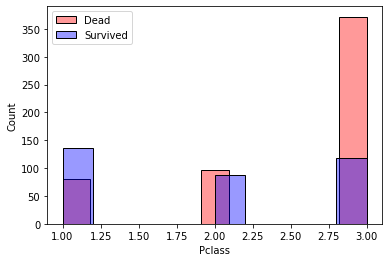

In [7]:
sns.histplot(train_df[train_df["Survived"]==0].Pclass, label="Dead", color="red", alpha=0.4)
sns.histplot(train_df[train_df["Survived"]==1].Pclass, label="Survived", color="blue", alpha=0.4)
plt.legend()

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

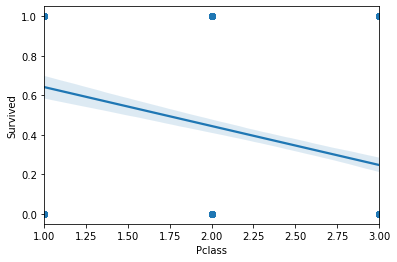

In [8]:
sns.regplot(x=train_df["Pclass"], y=train_df["Survived"])

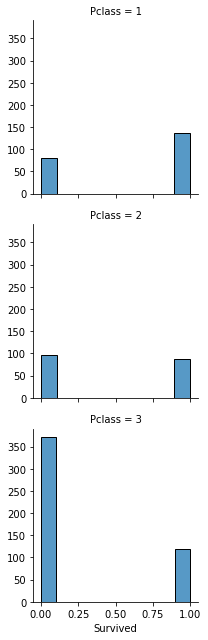

In [9]:
grid = sns.FacetGrid(train_df, row="Pclass")
grid.map(sns.histplot, "Survived")

In [10]:
train_df[["Pclass","Survived"]].groupby(["Pclass"],as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


# 위의 결과는 Pclass로 같은 insight를 주기위해 여러 방식을 사용해본것임<br><br>

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

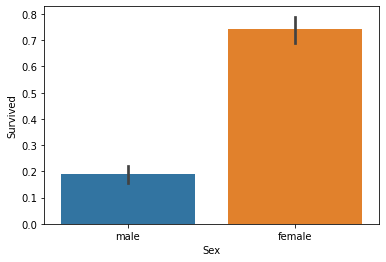

In [11]:
sns.barplot(x=train_df["Sex"], y=train_df["Survived"])

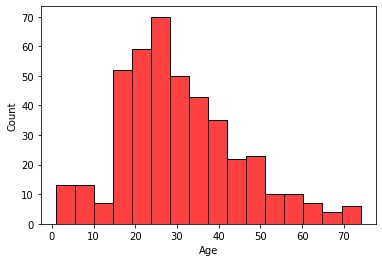

(0.0, 70.0)

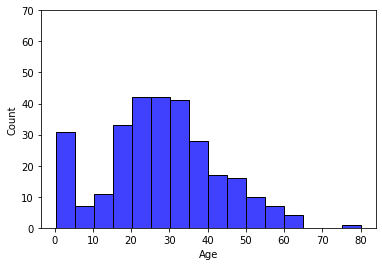

In [12]:
#Age특성은 10대 이상은 대부분 생존, 20~40대는 대부분 사망률이 높고 탑승객의 대다수를 차지함, 80대이상은 무조건 생존함
#이를 학습시키기 위해서 복잡한 모델을 사용하거나 Age특성을 범주형 값으로 만들어서 학습시켜야함
#또한 Age값은 null값이 존재하므로 이를 처리하기위한 적절한 방법을 모색해야함
sns.histplot(train_df[train_df["Survived"]==0].Age, label="Dead", color="red")
plt.show()
sns.histplot(train_df[train_df["Survived"]==1].Age, label="Survived", color="blue")
plt.ylim(0, 70)

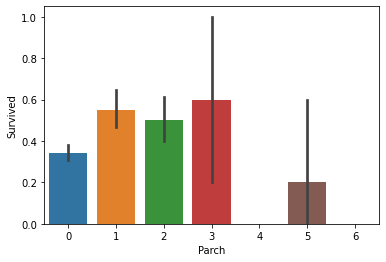

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

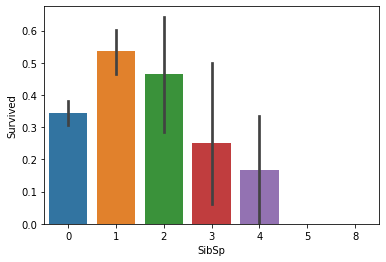

In [13]:
sns.barplot(x=train_df["Parch"], y=train_df["Survived"])
plt.show()
sns.barplot(x=train_df["SibSp"], y=train_df["Survived"])

<AxesSubplot:xlabel='Parch', ylabel='Count'>

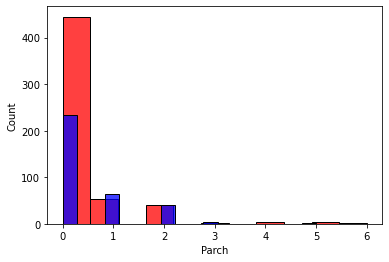

In [14]:
#막대그래프와달리 히스토그램에서는 그래프의 비율이아닌 속하는 값을 통해 보여주므로 데이터가 균등히 나눠져있지 않을때 용이함
#이 경우에는 0명인 경우와 그렇지 않은 경우의 샘플수가 확연히 차이나므로 그렇지 않은 모든 경우를 하나의 특성으로 모아서 전처리함
sns.histplot(train_df[train_df["Survived"]==0].Parch, label="Dead", color="red")
sns.histplot(train_df[train_df["Survived"]==1].Parch, label="Survived", color="blue")

<AxesSubplot:xlabel='SibSp', ylabel='Count'>

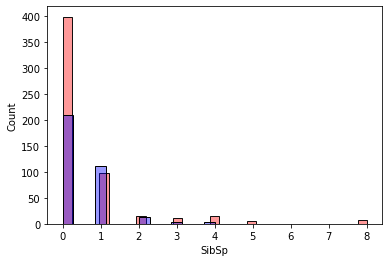

In [15]:
sns.histplot(train_df[train_df["Survived"]==0].SibSp, label="Dead", color="red", alpha=0.4)
sns.histplot(train_df[train_df["Survived"]==1].SibSp, label="Survived", color="blue", alpha=0.4)

In [16]:
train_df["IsAlone"] = (train_df["Parch"]==0) & (train_df["SibSp"]==0)
test_df["IsAlone"] = (test_df["Parch"]==0) & (test_df["SibSp"]==0)

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<AxesSubplot:xlabel='IsAlone', ylabel='Count'>

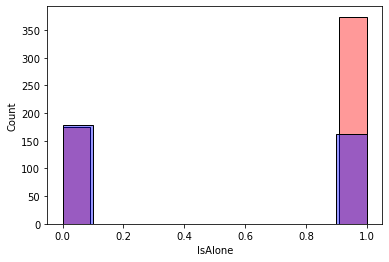

In [17]:
#샘플의 양이 충분히 크고 둘의 생존률이 차이를 보이므로 모델 학습에 도움을 줄 수 있는 특성이 되었음
sns.histplot(train_df[train_df["Survived"]==0].IsAlone, label="Dead", color="red", alpha=0.4)
sns.histplot(train_df[train_df["Survived"]==1].IsAlone, label="Survived", color="blue", alpha=0.4)

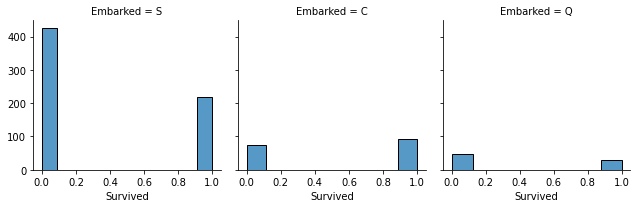

In [18]:
grid = sns.FacetGrid(train_df, col="Embarked")
grid.map(sns.histplot, "Survived")

###  Pclass, Isalone, Sex는 바로 사용한다
Age는 Nan값이 있으므로 전처리하고 사용하며 Parch, SisSp등 불필요한 특성도 이후 사용할지 모르니 가능한한 마지막에 제외시킨다

Age와 Embarked특성은 라벨값과 연관이 있으므로 학습에 사용할 것이다<br>
하지만 이들은 Nan값을 가지므로 값을 적절히 처리해야하며 이를 위한 방식 중 일단 당장 가능한 방법을 사용하겠다

In [19]:
#범주형값이며 Nan값이 있어 Labelencoder를 사용하지 못한다
train_df["Embarked"].replace("S",0,inplace=True)
train_df["Embarked"].replace("C",1,inplace=True)
train_df["Embarked"].replace("Q",2,inplace=True)
train_df["Embarked"].fillna(train_df["Embarked"].median(), inplace=True)
test_df["Embarked"].replace("S",0,inplace=True)
test_df["Embarked"].replace("C",1,inplace=True)
test_df["Embarked"].replace("Q",2,inplace=True)
test_df["Embarked"].fillna(train_df["Embarked"].median(), inplace=True)

In [20]:
train_df = pd.concat([train_df,pd.get_dummies(train_df["Embarked"])],axis=1)
test_df = pd.concat([test_df,pd.get_dummies(train_df["Embarked"])],axis=1)

### Age 전처리
Age특성은 생존률에 큰 영향을 끼치는건 확실하다 하지만 이 중 약 1/8이 Nan값이다<br>
제외시키기엔 너무 많은 값이므로 이를 적절한 값으로 전처리한다<br>
여러 특성들의 Age Nan인 샘플들과 모든 샘플을 비교해보면서 어떤 특성을 사용할지 판단한다<br>
Fare, IsAlone, Pclass의 중앙값을 사용하여 전처리하고 싶은데 <br>
Fare는 int형이라 범주형 값으로 바꿔주거나 다른 방식으로 전처리해줘야할 것 같은데 특성이 이미 선형이라 손대지 않았다

<AxesSubplot:xlabel='Fare', ylabel='Density'>

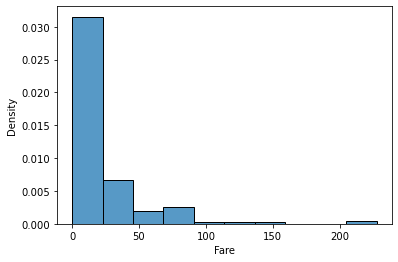

In [21]:
sns.histplot(train_df[train_df["Age"].isnull()].Fare, stat="density", bins=10)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

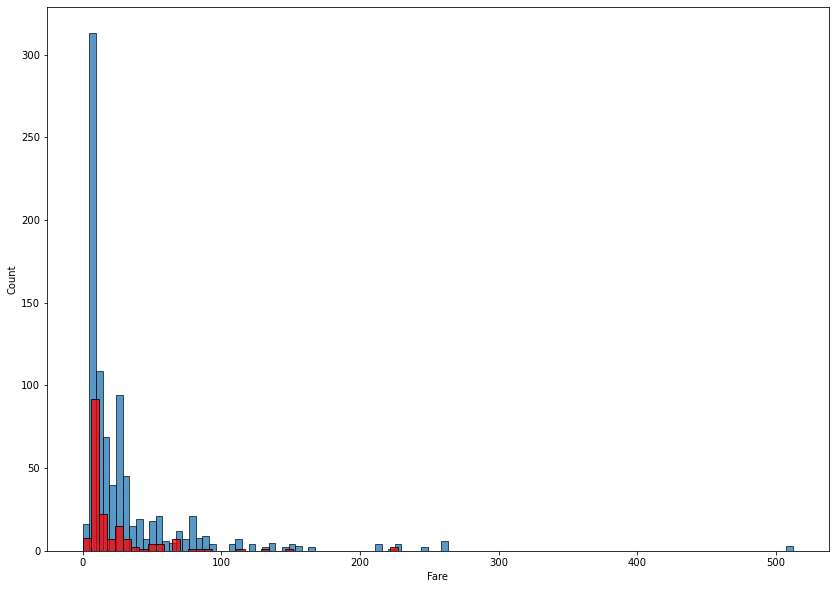

In [22]:
plt.figure(figsize=(14, 10))
sns.histplot(train_df["Fare"],stat="count")
sns.histplot(train_df[train_df["Age"].isnull()].Fare, color="red")

<AxesSubplot:xlabel='Pclass', ylabel='Count'>

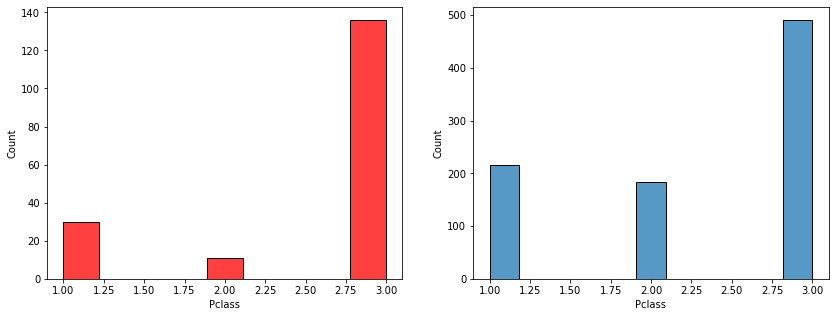

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(train_df[train_df["Age"].isnull()].Pclass, color="red")
plt.subplot(1,2,2)
sns.histplot(train_df["Pclass"])

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<AxesSubplot:xlabel='Sex', ylabel='Count'>

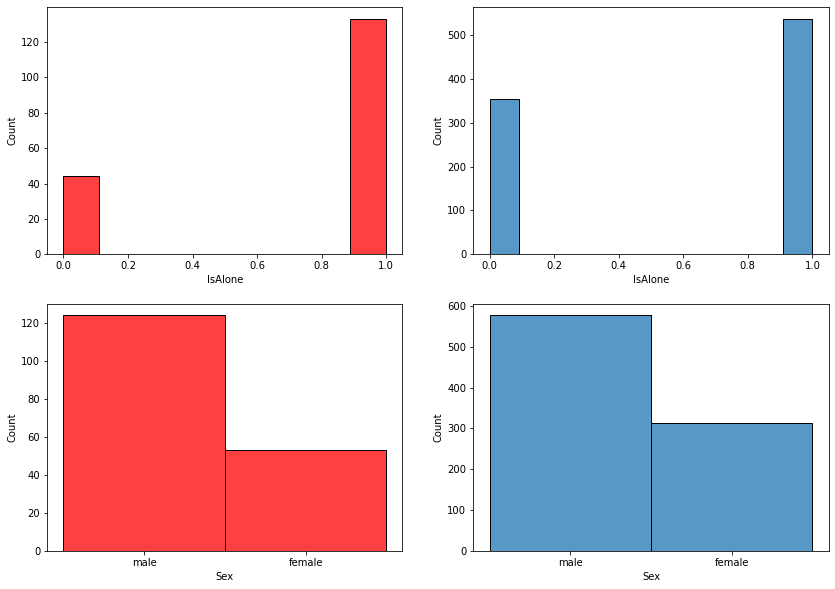

In [24]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
sns.histplot(train_df[train_df["Age"].isnull()].IsAlone, color="red")
plt.subplot(2,2,2)
sns.histplot(train_df["IsAlone"])
plt.subplot(2,2,3)
sns.histplot(train_df[train_df["Age"].isnull()].Sex, color="red")
plt.subplot(2,2,4)
sns.histplot(train_df["Sex"])

In [25]:
train_df["Sex"].replace("male",0,inplace=True)
train_df["Sex"].replace("female",1,inplace=True)
test_df["Sex"].replace("male",0,inplace=True)
test_df["Sex"].replace("female",1,inplace=True)

In [26]:
train_df['Age_Fill'] = train_df['Age'].groupby([train_df['Pclass'], train_df['IsAlone']]).apply(lambda x: x.fillna(x.mean()))
test_df['Age_Fill'] = test_df['Age'].groupby([test_df['Pclass'], test_df['IsAlone']]).apply(lambda x: x.fillna(x.mean()))

<AxesSubplot:xlabel='Age', ylabel='Count'>

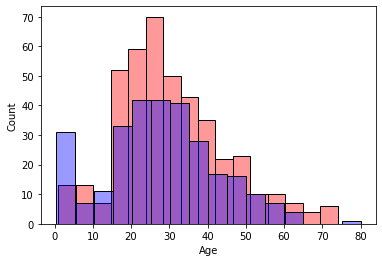

In [27]:
sns.histplot(train_df[train_df["Survived"]==0].Age, label="Dead", color="red", alpha=0.4)
sns.histplot(train_df[train_df["Survived"]==1].Age, label="Dead", color="blue", alpha=0.4)


### 특성공학은 완료했으므로 의미없는 특성을 떼주고 모델을 학습시킨다

In [28]:
train_label = train_df["Survived"]
train_df.drop(["SibSp", "Parch", "Name","Ticket","Age","Cabin","Survived","PassengerId"],axis=1, inplace=True)
test_df.drop(["SibSp", "Parch", "Name","Ticket","Age","Cabin"],axis=1, inplace=True)

In [29]:
train_df

,Pclass,Sex,Fare,Embarked,IsAlone,0.0,1.0,2.0,Age_Fill
0,3,0,7.2500,0.0,False,1,0,0,22.000
1,1,1,71.2833,1.0,False,0,1,0,38.000
2,3,1,7.9250,0.0,True,1,0,0,26.000
3,1,1,53.1000,0.0,False,1,0,0,35.000
4,3,0,8.0500,0.0,True,1,0,0,35.000
...,...,...,...,...,...,...,...,...,...
886,2,0,13.0000,0.0,True,1,0,0,27.000
887,1,1,30.0000,0.0,True,1,0,0,19.000
888,3,1,23.4500,0.0,False,1,0,0,19.784
889,1,0,30.0000,1.0,True,0,1,0,26.000


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [31]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(train_df, train_label)
logreg.score(train_df, train_label)

0.797979797979798

In [32]:
SVC = SVC()
SVC.fit(train_df, train_label)
SVC.score(train_df, train_label)

0.6801346801346801

In [33]:
random_forest = RandomForestClassifier()
random_forest.fit(train_df, train_label)
random_forest.score(train_df, train_label)

0.9820426487093153

In [34]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_df, train_label)
decision_tree.score(train_df, train_label)

0.9820426487093153

In [35]:
SGD = SGDClassifier()
SGD.fit(train_df, train_label)
SGD.score(train_df, train_label)

0.6936026936026936

In [36]:
models = [SVC, random_forest, decision_tree, SGD, logreg]
model_names = ["SVC","RandomForest","DecisionTree","SGD","LogisticRegression"]

### 과대적합 chk'후에 GridsearchCV적용후 마무리하기

In [37]:
def calculateCVscore(model):
    CVscore = cross_val_score(model, train_df, train_label, cv=10, scoring="accuracy").mean()
    CVscore = round(CVscore*100, 2)
    return CVscore

In [38]:
model_scores = list(map(calculateCVscore, models))
model_cv_scores = pd.DataFrame(model_scores, columns = ["model_scores"], index=model_names)

In [39]:
model_cv_scores

,model_scores
SVC,67.01
RandomForest,80.93
DecisionTree,77.67
SGD,67.56
LogisticRegression,79.13


In [44]:
svcParams = {"C": np.arange(6,13), 
              "kernel": ["linear","rbf"],
              "gamma": [0.5, 0.2, 0.1, 0.001, 0.0001]}
dtParams = {"max_features": ["auto", "sqrt", "log2"],
             "min_samples_split": np.arange(2,16), 
             "min_samples_leaf":np.arange(1,12)}
rfParams = {"criterion":["gini","entropy"],
             "n_estimators":[10, 15, 20, 25, 30],
             "min_samples_leaf":[1, 2, 3],
             "min_samples_split":np.arange(3,8), 
             "max_features":["sqrt", "auto", "log2"]}
logParams = {"penalty": ["l1","l2","elasticnet","none"],
            "C": [100,10,1,0.1,0.01,0.001,0.0001]}

In [46]:
def tuneHyperparameters(model, params):

    gridSearch = GridSearchCV(model, params, verbose=0, cv=10, scoring="accuracy", n_jobs = -1)
    gridSearch.fit(train_df, train_label)
    bestParams, bestScore = gridSearch.best_params_, round(gridSearch.best_score_*100, 2)
    return bestScore, bestParams

In [ ]:
model_names_to_tune = ["SVC","Randomforest","DecisionTree","Logisticregression"]
model_to_tune = [SVC, random_forest, decision_tree, logreg]
model_params=[svcParams, rfParams, dtParams, logParams]
bestscores = list(map(tuneHyperparameters, model_to_tune, model_params))

In [ ]:
tuned_result = pd.DataFrame(bestscores, index=model_names_to_tune,columns=["tunedAccuracy", "bestHyperparameters"])

In [ ]:
tuned_result